# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
    cartesian2polar, polarCurvature
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

#rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
#                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01', 'f02', 'f03']


### Compose mutli-fly data into dataframe

In [2]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [3]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [4]:
#vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        genotype = fileToAnalyse.split('_')[2][:-3]#[-5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/females/rawData/f01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_f01_out_160609172921.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_f01_out_160609155036.txt', 'stripe_BlackOnWhite_WTB_f01_out_160609171703.txt', 'stripe_Whiteonblack_WTB_f01_out_160609174042.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/females/rawData/f02/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_f02_out_160609181217.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_f02_out_160609182334.txt', 'stripe_BlackOnWhite_WTB_f02_out_160609183444.txt', 'stripe_Whiteonblack_WTB_f

In [5]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,sceneName,gamma,gammaFull,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,moving
0,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.000000,0,60.622000,NaN,35.000000,NaN,0
1,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.050020,0,60.622000,NaN,35.000000,NaN,0
2,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.100039,0,60.622000,NaN,35.000000,NaN,0
3,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.150059,0,60.622000,NaN,35.000000,NaN,0
4,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.200078,0,60.622000,NaN,35.000000,NaN,0
5,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.250098,0,60.622000,NaN,35.000000,NaN,0
6,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.300117,0,60.622000,NaN,35.000000,NaN,0
7,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,0.000000,0.350137,0,60.622000,NaN,35.000000,NaN,0
8,f01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,-0.079026,0.400156,0,60.622000,NaN,35.000000,NaN,0
9,f01,1,plane,1cm4cmCone,NaN,NaN,-0.003957,-0.079103,0.450176,0,60.622000,NaN,35.000000,NaN,0


In [6]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

genotypeSex = fileToAnalyse.split('_')[1][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Experimental conditions

In [7]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))

#### Heading angle distribution (if stripe)

In [8]:
genotypeSex = fileToAnalyse.split('_')[-4]+fileToAnalyse.split('_')[-3][0]

In [9]:
genotypeSex

'WTBf'

In [10]:
def plotHeadingComparison(sceneName,titleString,densityFlag):
    legendlist = []
    for fly in range(numFlies):
        legendlist.append(flyIDs[fly])

        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze()
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()


        gammaPlt = headingfig.add_subplot(221)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving>0],density=densityFlag,range=histRange,bins=18)
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
        else:
            gammaPlt.set_ylabel('count (when moving)')
        myAxisTheme(gammaPlt)

        gammaFullPlt = headingfig.add_subplot(222)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],density=densityFlag,range=histRange,bins=36)
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color=flyCMap.to_rgba(fly))
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt)

        gammaPlt = headingfig.add_subplot(223)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving==0],density=densityFlag,range=histRange,bins=18)
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaPlt.set_xlim(histRange)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when standing)')
        else:
            gammaPlt.set_ylabel('count (when standing)')
        myAxisTheme(gammaPlt)

        gammaFullPlt = headingfig.add_subplot(224)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving==0],density=densityFlag,range=histRange,bins=36)
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        gammaFullPlt.legend(legendlist)
        myAxisTheme(gammaFullPlt)

    headingfig.suptitle(titleString,fontsize=13)
    headingfig.tight_layout

    return headingfig

In [11]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


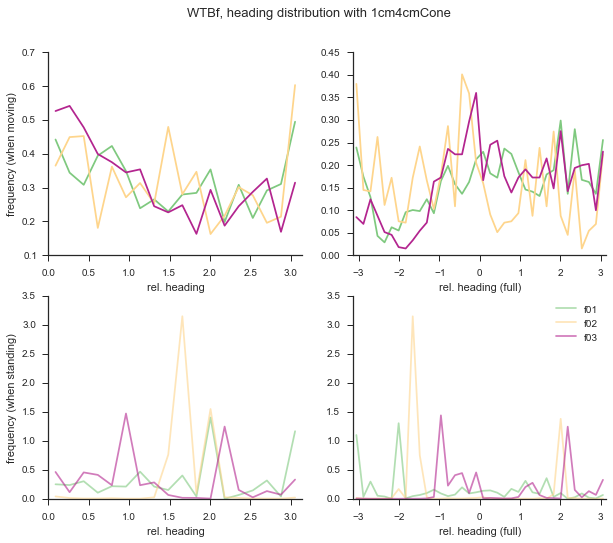

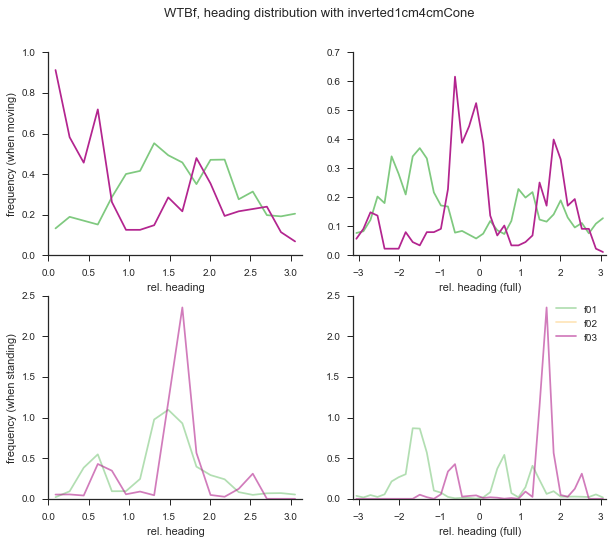

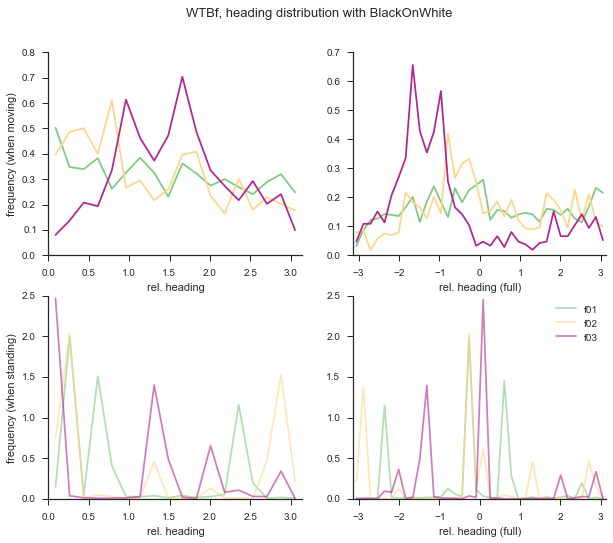

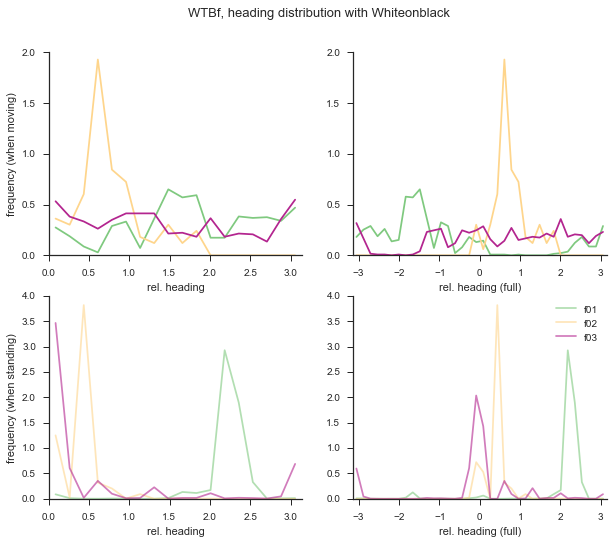

In [12]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_n'+str(numFlies)+'.pdf', format = 'pdf')

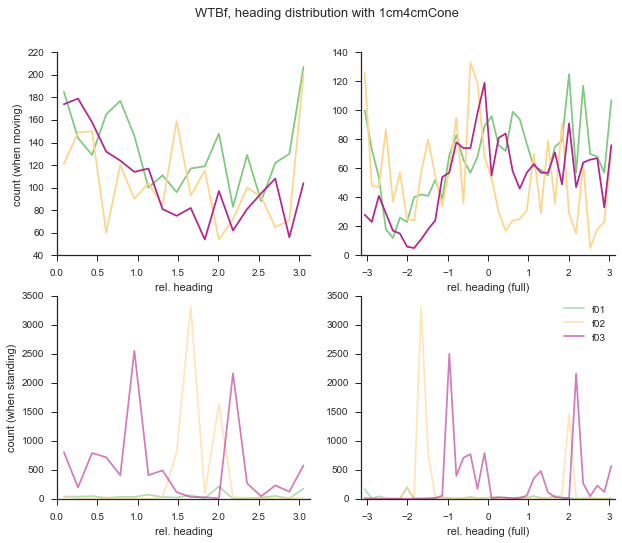

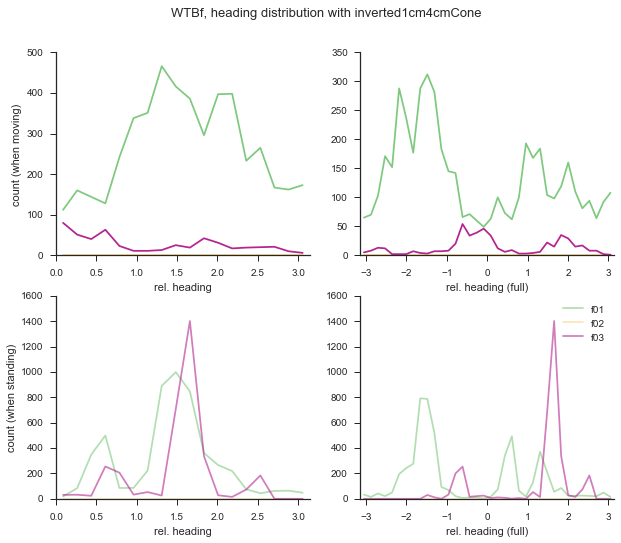

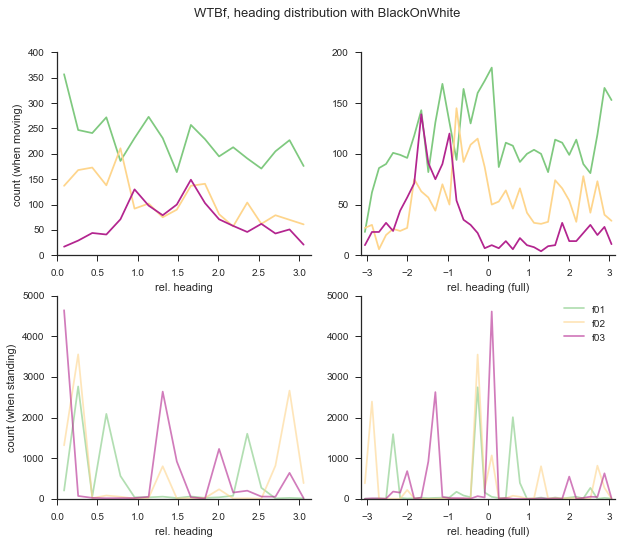

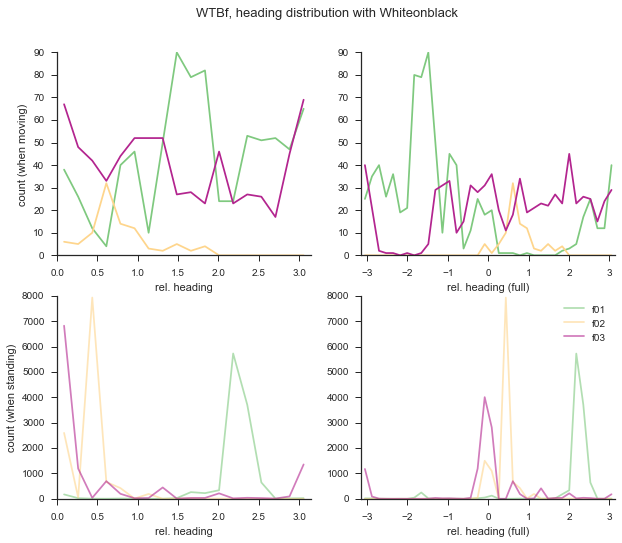

In [13]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_n'+str(numFlies)+'.pdf', format = 'pdf')